In [1]:
!pip install -qq transformers
!pip install -qq datasets

In [2]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import random
from textwrap import wrap
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# the model we gonna train, base uncased BERT
MODEL_NAME = "bert-base-uncased" 
# max sequence length for each document/sentence sample
MAX_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE= 1e-5
RANDOM_SEED=2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }


def model_init():
  temp_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)
  return temp_model

# Code modified from Stabilizer library to handle DistilBERT architecture
#https://github.com/flowerpot-ai/stabilizer




def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)

In [5]:
set_seed(2)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [7]:
timestamp()

16-Feb-2022 (00:05:32.807737)


In [8]:
result_list = []
for i in range(1,11):
  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/bert/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    learning_rate=LEARNING_RATE, 
    logging_dir='./bert/logs/'+str(i),     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",     # evaluate each `logging_steps`
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids","attention_mask"])
  train_dataset = train_dataset.rename_column("input_ids_bert","input_ids")
  train_dataset = train_dataset.rename_column("attention_mask_bert","attention_mask")
  train_dataset = train_dataset.rename_column("token_type_ids_bert","token_type_ids_mask")
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids","attention_mask"])
  eval_dataset = eval_dataset.rename_column("input_ids_bert","input_ids")
  eval_dataset = eval_dataset.rename_column("attention_mask_bert","attention_mask")
  eval_dataset = eval_dataset.rename_column("token_type_ids_bert","token_type_ids_mask")
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids","attention_mask"])
  test_dataset = test_dataset.rename_column("input_ids_bert","input_ids")
  test_dataset = test_dataset.rename_column("attention_mask_bert","attention_mask")
  test_dataset = test_dataset.rename_column("token_type_ids_bert","token_type_ids_mask")
  model = model_init()
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/bert/models/model_'+str(i))
  results = trainer.evaluate(hatetwit_dataset_dfs ["test"])
  results["model_run"] = i
  result_list.append(results)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.607200,0.560791,0.773557,0.730820,0.726028,0.736744,0.716619,0.750503,0.685662,0.848758,0.835246,0.862715,0.627083,0.624481,0.629707
2,0.520700,0.520584,0.788367,0.741296,0.746164,0.741315,0.743237,0.787726,0.703504,0.860662,0.866716,0.854691,0.619989,0.569502,0.680297
3,0.463100,0.516819,0.795235,0.750414,0.751433,0.754162,0.751402,0.808853,0.701571,0.866914,0.863384,0.870474,0.632925,0.590249,0.682254


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/1/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/1/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/1/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/1/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.599600,0.553356,0.776132,0.719509,0.739003,0.705641,0.705512,0.676056,0.737651,0.855626,0.895224,0.819383,0.597388,0.545643,0.659975
2,0.521000,0.527916,0.786006,0.737240,0.740965,0.739884,0.734884,0.794769,0.683391,0.862324,0.862643,0.862005,0.614512,0.562241,0.677500
3,0.457600,0.517896,0.787723,0.740926,0.742239,0.742182,0.738506,0.775654,0.704753,0.862636,0.863754,0.861521,0.621636,0.587137,0.660443


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/2/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/2/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/2/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/2/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.598700,0.575654,0.762395,0.711223,0.714413,0.710108,0.703307,0.727364,0.680791,0.843033,0.850056,0.836125,0.587328,0.552905,0.626322
2,0.512200,0.555892,0.774200,0.711596,0.737323,0.710554,0.728102,0.802817,0.666110,0.855446,0.879674,0.832516,0.551241,0.449170,0.713344
3,0.452400,0.547150,0.784503,0.735937,0.740609,0.734983,0.742308,0.776660,0.710866,0.858662,0.867086,0.850399,0.606842,0.561203,0.660562


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/3/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/3/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/3/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/3/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.608000,0.579239,0.767761,0.706370,0.734351,0.693952,0.709453,0.717304,0.701772,0.846695,0.891522,0.806160,0.562963,0.473029,0.695122
2,0.519500,0.587072,0.757459,0.717007,0.709512,0.735992,0.714224,0.830986,0.626232,0.832620,0.791929,0.877719,0.604178,0.585062,0.624585
3,0.454700,0.548608,0.780640,0.733055,0.737790,0.733154,0.737892,0.781690,0.698741,0.853363,0.859682,0.847136,0.607910,0.558091,0.667494


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/4/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/4/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/4/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/4/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.596900,0.554762,0.776561,0.728339,0.732131,0.725209,0.718077,0.721328,0.714855,0.853377,0.863014,0.843954,0.613563,0.591286,0.637584
2,0.517000,0.526863,0.784718,0.740120,0.740115,0.745287,0.739574,0.802817,0.685567,0.857036,0.850056,0.864132,0.623751,0.582988,0.670644
3,0.462200,0.523563,0.789011,0.742359,0.745438,0.744895,0.742991,0.799799,0.693717,0.862114,0.862273,0.861954,0.621972,0.572614,0.680641


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/5/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/5/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/5/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/5/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.605200,0.555847,0.770766,0.720922,0.726167,0.717812,0.710565,0.727364,0.694524,0.848219,0.859682,0.837058,0.603982,0.566390,0.646919
2,0.521400,0.534285,0.779566,0.731602,0.735105,0.732621,0.727187,0.773642,0.685995,0.854824,0.857830,0.851838,0.612795,0.566390,0.667482
3,0.453900,0.528043,0.784932,0.738882,0.739916,0.742370,0.740984,0.795775,0.693252,0.858310,0.855609,0.861028,0.617353,0.575726,0.665468


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/6/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/6/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/6/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/6/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.607600,0.567196,0.770122,0.724400,0.723855,0.725141,0.724121,0.735412,0.713171,0.846239,0.845613,0.846867,0.602841,0.594398,0.611526
2,0.518300,0.537031,0.781713,0.732854,0.738051,0.736380,0.738631,0.808853,0.679628,0.856244,0.856720,0.855769,0.603687,0.543568,0.678756
3,0.468000,0.534948,0.784932,0.739856,0.739425,0.743492,0.746692,0.794769,0.704100,0.857408,0.853758,0.861090,0.615469,0.581950,0.653085


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/7/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/7/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/7/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/7/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.601800,0.585181,0.758103,0.713602,0.706465,0.724536,0.706968,0.770624,0.653026,0.838451,0.813773,0.864673,0.595388,0.589212,0.601695
2,0.517300,0.539925,0.781927,0.736426,0.736778,0.736293,0.734228,0.743461,0.725221,0.856984,0.858571,0.855404,0.618067,0.606846,0.629709
3,0.458600,0.543635,0.781927,0.736523,0.736336,0.740006,0.744802,0.792757,0.702317,0.854542,0.851536,0.857569,0.610225,0.575726,0.649123


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/8/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/8/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/8/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/8/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.602700,0.575228,0.765400,0.711267,0.726456,0.700009,0.686335,0.667002,0.706823,0.844096,0.875972,0.814458,0.603371,0.557054,0.658088
2,0.515800,0.540109,0.782142,0.733457,0.741240,0.730648,0.730159,0.763581,0.699539,0.855527,0.868197,0.843222,0.614684,0.560166,0.680958
3,0.446000,0.544680,0.787293,0.744247,0.744398,0.745885,0.747592,0.780684,0.717190,0.856825,0.856350,0.857302,0.628323,0.600622,0.658703


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/9/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/9/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/9/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/9/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/bert/re

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 307

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.605800,0.555729,0.779137,0.730440,0.732797,0.729456,0.712610,0.733400,0.692966,0.857721,0.862643,0.852855,0.620990,0.592324,0.652571
2,0.512500,0.523541,0.790084,0.739669,0.746424,0.736219,0.729400,0.752515,0.707663,0.867408,0.880415,0.854781,0.622197,0.575726,0.676829
3,0.459800,0.527571,0.793733,0.744209,0.752075,0.741867,0.736138,0.774648,0.701275,0.868993,0.880415,0.857864,0.627496,0.570539,0.697085


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/10/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/bert/results/10/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/bert/results/10/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_type_ids_mask, sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/bert/results/10/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/ber

In [9]:
timestamp()

16-Feb-2022 (01:38:12.460922)


In [10]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/bert_baselines.csv')


In [11]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])


In [12]:
#Print min values 
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
1,0.534123,0.781237,0.732864,0.735147,0.734031,0.740811,0.78147,0.704174,0.856669,0.86,0.853363,0.601111,0.560622,0.647904,6.6495,700.499,21.956,3.0,2


In [13]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
3,0.53366,0.796264,0.748941,0.757816,0.74821,0.751527,0.805639,0.704225,0.866825,0.876296,0.857557,0.628472,0.562694,0.711664,6.2582,744.306,23.329,3.0,4


In [14]:
#Print median f1
results_df["eval_f1"].median()

0.739697657732783

In [15]:
#Print average values
results_df.mean()

eval_loss                     0.534259
eval_accuracy                 0.787720
eval_f1                       0.740537
eval_precision                0.744674
eval_recall                   0.740911
eval_hate_f1                  0.743993
eval_hate_recall              0.786103
eval_hate_precision           0.706472
eval_offensive_f1             0.860770
eval_offensive_recall         0.865852
eval_offensive_precision      0.855807
eval_normal_f1                0.616849
eval_normal_recall            0.570777
eval_normal_precision         0.671744
eval_runtime                  6.090190
eval_samples_per_second     767.173500
eval_steps_per_second        24.046100
epoch                         3.000000
model_run                     5.500000
dtype: float64

In [16]:
results_df.std()

eval_loss                    0.011483
eval_accuracy                0.005688
eval_f1                      0.005878
eval_precision               0.007528
eval_recall                  0.005517
eval_hate_f1                 0.005697
eval_hate_recall             0.014494
eval_hate_precision          0.012071
eval_offensive_f1            0.005826
eval_offensive_recall        0.009405
eval_offensive_precision     0.006139
eval_normal_f1               0.011002
eval_normal_recall           0.016615
eval_normal_precision        0.020409
eval_runtime                 0.360022
eval_samples_per_second     43.944597
eval_steps_per_second        1.377354
epoch                        0.000000
model_run                    3.027650
dtype: float64

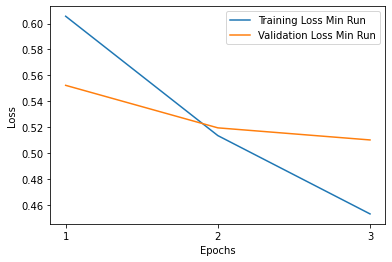

In [17]:
training_loss_min = [0.6056,0.51370,0.4534]
training_loss_max = [0.608,0.5195,0.4547]
val_loss_min = [0.5524,0.519667,0.510353]
val_loss_max = [0.5792,0.5870,0.5486]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()


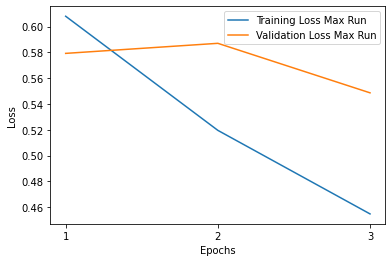

In [18]:

plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()